# Infering the Parameters

We have our data and our simulation (see data_explore and model_simulation), now we need to estimate the parameters. In this notebook, we will assume that all parameters are the same between individuals and that variation between individuals is simply due to some error on each observation. This method of parameter estimation is Naive Pooled Inference.

In [1]:
!pip install ipynb
!pip install ./pints-master

Processing ./pints-master
  Created wheel for pints: filename=pints-0.2.2-cp37-none-any.whl size=229011 sha256=1087468cddb45ff14d4db688a8971e667232807b949708ae02f5ca5411218532
  Stored in directory: /home/rumneyr/.cache/pip/wheels/23/f1/0b/7f6d8d6d6358237dd5757166c40f8f414a896a8f6f3b677add
Successfully built pints
  Found existing installation: pints 0.2.2
    Uninstalling pints-0.2.2:
      Successfully uninstalled pints-0.2.2


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints
import pints.plot
import pandas
import plotly.express as px
import plotly.graph_objects as go

## Pharmacokenetics - Linear Model

Let's begin with the Linear Pharmacokenetic model. We will first see whether we can fit the model to simulated data before trying to fit to the real data.

### Simulated Data

In [2]:
from ipynb.fs.full.model_simulation import PK_iv_result # import the required model

# Options
# (only num_comp really affects the model in the simulated case)
drug = 'Simulated Drug'
dose = 2
num_comp = 2

# Actual Parameters
# (This is only to produce the simulated data. These are 'unknown' when doing the inference)
Vol_C = 1
Cl = 2.5
Vol_perif = 0.5
Q_perif = 2.3

actual_parameters = [Vol_C, Cl, Vol_perif, Q_perif]
np.save('simulated_parameters_actual_dose'+str(dose), np.array(actual_parameters))

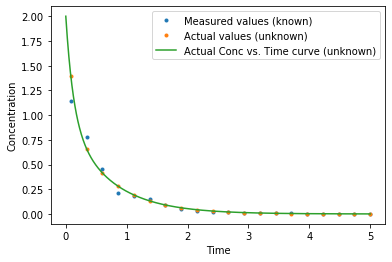

In [3]:
# Create the Data
time_span = 5
num_obs = 20

data_times = np.concatenate((np.array([0]), np.linspace(0.083, time_span, num_obs)))
# data_times = [0, 0.083, 0.333,  2.5, 4.666, 4.833, 5] 
# Uncomment the above line if you want the simulated data to mimic the real data

noise = np.random.normal(0, 0.15, len(data_times))
values_no_noise = PK_iv_result(dose, num_comp, actual_parameters, data_times)[:,0]
values_noisey = np.exp(np.log(values_no_noise) + noise)
df = pandas.DataFrame({'TIME' : data_times[1:], 'OBS' : values_noisey[1:]})

more_times = np.linspace(0,time_span,1000)
more_values = PK_iv_result(dose, num_comp, actual_parameters, more_times)[:,0]

# Visualise the data
plt.plot(df['TIME'], df['OBS'], '.', label='Measured values (known)')
plt.plot(data_times[1:], values_no_noise[1:], '.', label='Actual values (unknown)')
plt.plot(more_times, more_values, label='Actual Conc vs. Time curve (unknown)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [4]:
# df.to_csv(r'sythesised_data_real_timepoints.csv', index = False)
# df['OBS'] = df['OBS'].abs()
# df['log_value'] = np.log(df['OBS'])
print(df)

        TIME       OBS
0   0.083000  1.144590
1   0.341789  0.782243
2   0.600579  0.453044
3   0.859368  0.216261
4   1.118158  0.184871
5   1.376947  0.146927
6   1.635737  0.091260
7   1.894526  0.054397
8   2.153316  0.033584
9   2.412105  0.022188
10  2.670895  0.021442
11  2.929684  0.011689
12  3.188474  0.007838
13  3.447263  0.006265
14  3.706053  0.005515
15  3.964842  0.003586
16  4.223632  0.002208
17  4.482421  0.001350
18  4.741211  0.001200
19  5.000000  0.000618


In [5]:
# Create the model in PINTS 

class PintsLinCompIV(pints.ForwardModel):
    def n_parameters(self):
        return num_comp*2
    def simulate(self, parameter, times):
        if times[0] == 0:
            return PK_iv_result(dose, num_comp, parameter, times)[:,0]
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However our model assumes dosing happens at t=0 so we will need to add 0 to the times array and
            # then ignore the result at t=0.
            times = np.concatenate((np.array([0]), times))
            curve = PK_iv_result(dose, num_comp, parameter, times)[1:,0]
            # print(curve[curve<=0])
            return curve
        
class RatioError(pints.ProblemErrorMeasure):
    """
    Calculates a sum-of-squares error: ``f = sum( (log10(x[i]) -log10( y[i])**2 )``
    Extends :class:`ErrorMeasure`.
    Parameters
    ----------
    problem
        A :class:`pints.SingleOutputProblem` or
        :class:`pints.MultiOutputProblem`.
    """

    def __init__(self, problem, weights=None):
        super(RatioError, self).__init__(problem)

        if weights is None:
            weights = [1] * self._n_outputs
        elif self._n_outputs != len(weights):
            raise ValueError(
                'Number of weights must match number of problem outputs.')
        # Check weights
        self._weights = np.asarray([float(w) for w in weights])

    def __call__(self, x):
        return np.sum((np.sum((((self._problem.evaluate(x) - self._values) / self._values) ** 2),
                              axis=0) * self._weights),
                      axis=0)

In [6]:
# Before starting the optimisation we should estimate the parameter Vol_C. We can do this by drawing a line 
# through the first 2 point and seeing where it crosses the y-axis
point_1 = (df['TIME'][0], df['OBS'][0])
point_2 = (df['TIME'][1], df['OBS'][1])
y_0 = point_1[1] - (point_1[1] - point_2[1])/(point_1[0] - point_2[0]) * point_1[0]
Vol_C_approx = y_0/dose
print(point_1, point_2, y_0, Vol_C_approx)

(0.083, 1.1445900321115283) (0.34178947368421053, 0.7822429393136558) 1.2608034478817631 0.6304017239408816


Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      16.81433   0:00.1
1     16     14.78666   0:00.1
2     24     13.16168   0:00.1
3     32     10.28108   0:00.2
20    168    10.28108   0:00.6
40    328    7.649593   0:01.5
60    488    3.604945   0:03.0
80    648    0.578      0:04.9
100   808    0.555288   0:07.1
120   968    0.55       0:09.2
140   1128   0.498      0:10.6
160   1288   0.417      0:11.8
180   1448   0.417      0:12.7
200   1608   0.387      0:13.4
220   1768   0.36       0:14.0
240   1928   0.36       0:14.6
260   2088   0.36       0:15.2
280   2248   0.36       0:15.8
300   2408   0.36       0:16.4
320   2568   0.36       0:17.0
340   2728   0.36       0:17.7
360   2888   0.36       0:18.3
380   3048   0.36       0:18.9
400   3208   0.36       0:19.5
420   3368   0.36       0:20.1
440   3528   0.36       0:20.7
460   3688   0.36       0:21

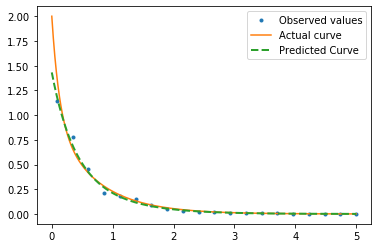

In [7]:
# Optimise the model with respect to the data
problem = pints.SingleOutputProblem(PintsLinCompIV(), df['TIME'].to_numpy(), df['OBS'].to_numpy())
error_measure = RatioError(problem)
lower_bound = [0.01, 0.01, 0.01, 0.01]
upper_bound = [100, 100, 100, 100]
optimisation = pints.OptimisationController(error_measure, [Vol_C_approx, 1, 1, 1], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters1, error1 = optimisation.run()

optimisation = pints.OptimisationController(error_measure, parameters1, method=pints.PSO, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()

# Show results
print('\t\t Run 1 \t\t\t\t\t Run2 \t\t\t\t\t Real')
print('Result: \t'+str(parameters1)+'\t'+str(parameters)+'\t'+str([Vol_C, Cl, Vol_perif, Q_perif]))
print('Error: \t\t'+str(error1)+'\t\t\t'+str(error)+'\t\t\t'+str(error_measure([Vol_C, Cl, Vol_perif, Q_perif])))
plt.figure()
plt.plot(df['TIME'],  df['OBS'], '.', label='Observed values')
plt.plot(more_times, more_values, label='Actual curve')
plt.plot(more_times, PK_iv_result(dose, num_comp, parameters, more_times)[:,0], '--', lw=2, label='Predicted Curve')
plt.legend()

In [8]:
# Lets Visualise using Plotly

y_label = drug + " Concentration"
x_label = "Time"

fig = px.scatter(
    df,
    title=drug + " Concentration Mean",
    x="TIME",
    y="OBS",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=more_times, y=PintsLinCompIV().simulate(parameters, more_times),
                    mode='lines',
                    name='Prediction'))
fig.add_trace(go.Scatter(x=more_times, y=more_values,
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(x=[0, point_2[0]], y=[y_0, point_2[1]],
                    mode='lines',
                    name='Y-axis intercept prediction'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

This is a useful way of estimating the correct parameters and visualising how good the model and estimated parameters fit the data. However, it would also be useful to know how sure we are on these parameter values. To do this we use Bayesian inference and MCMC to sample the parameter space and give a distribution of probable parameter values.

[2.09537083 4.00992968 0.30899043 0.68907507 0.15      ]
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0          0:00.0
2     9      0.333     0         0.333      0:00.0
3     12     0.5       0.25      0.5        0:00.0
20    63     0.381     0.19      0.571      0:00.2
40    123    0.293     0.146     0.537      0:00.4
60    183    0.295082  0.0984    0.459      0:00.6
80    243    0.247     0.0864    0.42       0:00.9
100   303    0.218     0.0693    0.356      0:01.1
120   363    0.198     0.0579    0.306      0:01.4
140   423    0.177305  0.0496    0.27       0:01.6
160   483    0.161     0.0435    0.248      0:01.8
180   543    0.160221  0.0497    0.221      0:02.0
Initial phase completed.
200   603    0.154     0.0547    0.199005   0:02.2
220   663    0.19      0.0995    0.226      0:02.5
240   

3100  9303   0.211     0.207     0.212      0:25.0
3120  9363   0.211     0.207     0.211      0:25.1
3140  9423   0.211     0.208     0.211      0:25.2
3160  9483   0.211     0.208     0.211      0:25.3
3180  9543   0.212     0.209     0.212      0:25.5
3200  9603   0.212746  0.209     0.212      0:25.6
3220  9663   0.214     0.209     0.212      0:25.7
3240  9723   0.215     0.21      0.213      0:25.9
3260  9783   0.215578  0.208525  0.213      0:26.0
3280  9843   0.215     0.208473  0.213      0:26.1
3300  9903   0.214     0.209     0.212      0:26.2
3320  9963   0.213791  0.208     0.212      0:26.3
3340  10023  0.215     0.208     0.212      0:26.4
3360  10083  0.214817  0.208     0.212      0:26.5
3380  10143  0.215     0.209     0.211      0:26.7
3400  10203  0.214     0.208     0.211      0:26.8
3420  10263  0.215     0.208     0.211      0:26.9
3440  10323  0.215635  0.208079  0.210404   0:27.0
3460  10383  0.216     0.207     0.211      0:27.1
3480  10443  0.215     0.207   

6320  18963  0.214     0.216     0.222275   0:43.8
6340  19023  0.214     0.216212  0.222      0:44.0
6360  19083  0.214     0.216161  0.222      0:44.1
6380  19143  0.214     0.216267  0.222      0:44.2
6400  19203  0.214     0.217     0.223      0:44.3
6420  19263  0.214     0.217     0.223      0:44.5
6440  19323  0.214     0.216426  0.223      0:44.6
6460  19383  0.215     0.216     0.223      0:44.7
6480  19443  0.216     0.215     0.223      0:44.9
6500  19503  0.215813  0.216     0.223      0:45.0
6520  19563  0.216     0.216     0.223      0:45.1
6540  19623  0.216     0.217     0.223      0:45.3
6560  19683  0.216278  0.217     0.223      0:45.4
6580  19743  0.216     0.217     0.223      0:45.6
6600  19803  0.216     0.217     0.222845   0:45.8
6620  19863  0.216     0.217     0.223      0:45.9
6640  19923  0.217     0.217136  0.223      0:46.0
6660  19983  0.216484  0.217     0.223      0:46.2
6680  20043  0.216734  0.217     0.223      0:46.3
6700  20103  0.217     0.217   

9560  28683  0.222     0.219     0.221      1:04.3
9580  28743  0.223     0.219     0.221      1:04.5
9600  28803  0.223     0.22      0.221      1:04.6
9620  28863  0.223     0.22      0.221      1:04.7
9640  28923  0.223     0.22      0.221      1:04.8
9660  28983  0.223     0.22      0.221      1:05.0
9680  29043  0.224     0.22      0.221      1:05.1
9700  29103  0.223     0.22      0.221      1:05.2
9720  29163  0.223     0.22      0.222      1:05.4
9740  29223  0.223     0.22      0.222      1:05.5
9760  29283  0.224     0.22      0.221801   1:05.6
9780  29343  0.224     0.22      0.222      1:05.8
9800  29403  0.224     0.22      0.222      1:05.9
9820  29463  0.225     0.22      0.222      1:06.1
9840  29523  0.224     0.221     0.222      1:06.2
9860  29583  0.224     0.221     0.222      1:06.3
9880  29643  0.224     0.221     0.222      1:06.5
9900  29703  0.224     0.221     0.222      1:06.6
9920  29763  0.224     0.221     0.221      1:06.7
9940  29823  0.224     0.221   

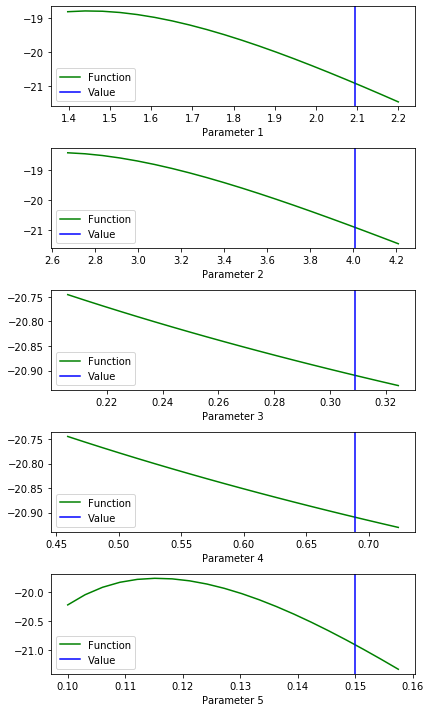

In [9]:
log_likelihood = pints.GaussianLogLikelihood(problem)

lower_bound_prior = [1e-3]*4 + [0]
upper_bound_prior = [1e3]*5
log_prior = pints.UniformLogPrior(lower_bound_prior, upper_bound_prior)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

upper =np.concatenate((np.asarray(parameters)*1.5, np.asarray([0.15])))
middle = np.concatenate((np.asarray(parameters), np.asarray([0.1])))
lower =np.concatenate((np.asarray(parameters)*0.5, np.asarray([0.05])))

pints.plot.function(log_posterior, upper, lower=middle, evaluations=20)
print(upper)

startpoints =  [upper, middle, lower]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(10000)
mcmc.set_log_to_screen(False)
samples = mcmc.run()

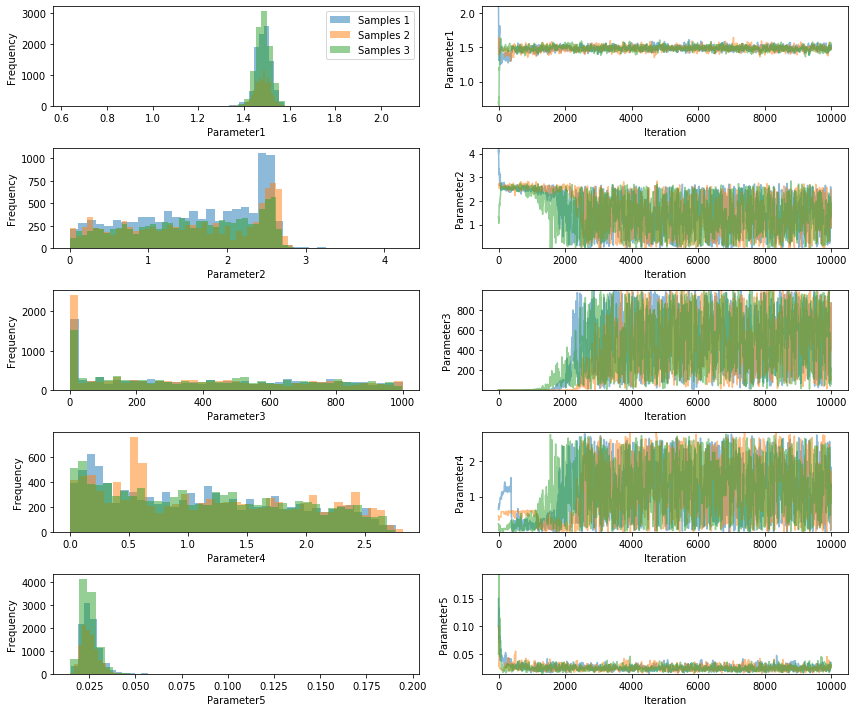

In [10]:
pints.plot.trace(samples)
plt.show()

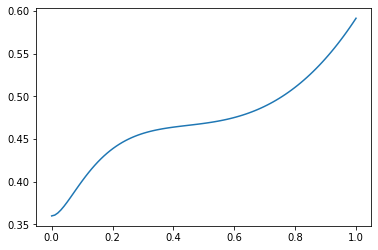

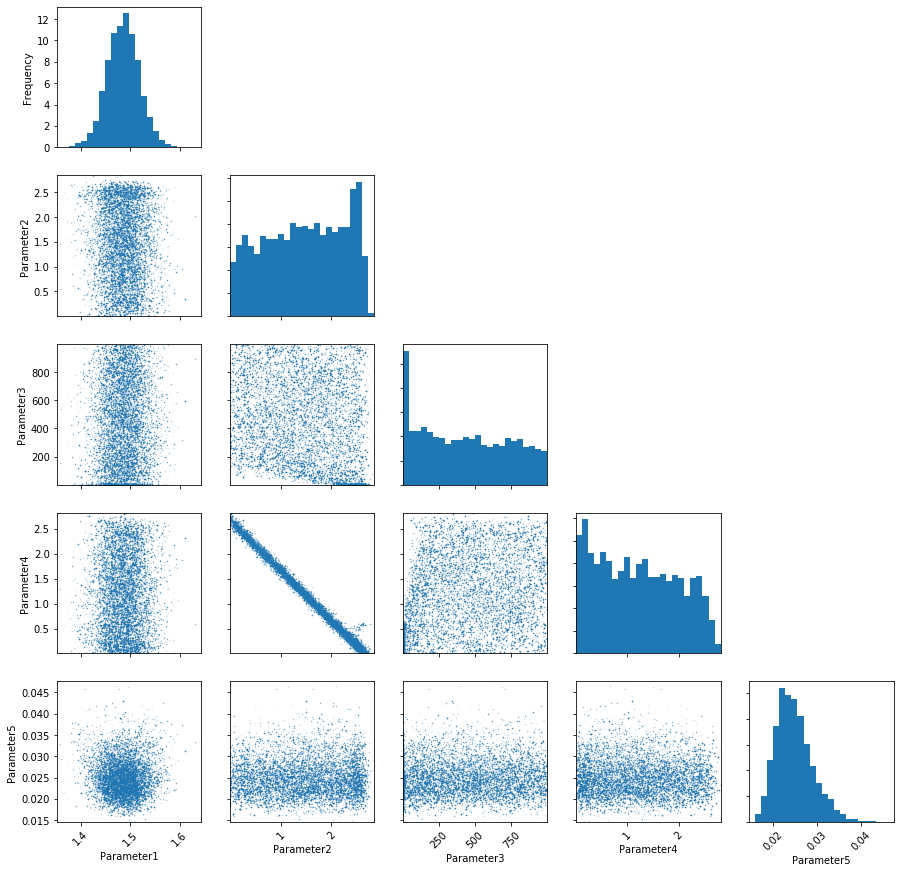

In [11]:
num_points = 100
P_0 = np.asarray([Vol_C, Cl, Vol_perif, Q_perif])
P_1 = parameters1
errors = []
xs = np.linspace(0, 1, num_points)

for x in xs:
    point = x*P_0+(1-x)*P_1
    errors.append(error_measure(point))
    
plt.plot(xs, errors)
plt.show()

pints.plot.pairwise(np.vstack(samples[:,1000:]))
plt.show()

In [12]:
# Multiple Runs of the optimiser to visualise the stability

df_stability = pandas.DataFrame(columns=['Optimiser', 'Vol_C', 'Cl', 'Vol_perif', 'Q_perif', 'Error'])
num_runs = 25
optimisers = {'CMAES': pints.CMAES, 'PSO' : pints.PSO, 'XNES' : pints.XNES, 'SNES' : pints.SNES}
initial_parameters = np.concatenate((np.ones((num_runs,1))*Vol_C_approx, np.random.uniform(low=1E-2, high=1E2, size=(num_runs, num_comp*2 - 1))), axis=1)

for opt in optimisers:
    for i in range(num_runs):
        print('Performing '+opt+' optimisation, run number: '+str(i+1))
        optimisation = pints.OptimisationController(error_measure, initial_parameters[i], method=optimisers[opt], boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
        optimisation.set_log_to_screen(False)
        parameters, error = optimisation.run()
        df_stability = df_stability.append({'Optimiser': opt, 'Vol_C': parameters[0], 'Cl': parameters[1], 'Vol_perif': parameters[2], 'Q_perif': parameters[3], 'Error': error}, ignore_index=True)

Performing CMAES optimisation, run number: 1
Performing CMAES optimisation, run number: 2
Performing CMAES optimisation, run number: 3
Performing CMAES optimisation, run number: 4
Performing CMAES optimisation, run number: 5
Performing CMAES optimisation, run number: 6
Performing CMAES optimisation, run number: 7
Performing CMAES optimisation, run number: 8
Performing CMAES optimisation, run number: 9
Performing CMAES optimisation, run number: 10
Performing CMAES optimisation, run number: 11
Performing CMAES optimisation, run number: 12
Performing CMAES optimisation, run number: 13
Performing CMAES optimisation, run number: 14
Performing CMAES optimisation, run number: 15
Performing CMAES optimisation, run number: 16
Performing CMAES optimisation, run number: 17
Performing CMAES optimisation, run number: 18
Performing CMAES optimisation, run number: 19
Performing CMAES optimisation, run number: 20
Performing CMAES optimisation, run number: 21
Performing CMAES optimisation, run number: 

/home/rumneyr/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



Performing PSO optimisation, run number: 4
Performing PSO optimisation, run number: 5
Performing PSO optimisation, run number: 6
Performing PSO optimisation, run number: 7
Performing PSO optimisation, run number: 8
Performing PSO optimisation, run number: 9
Performing PSO optimisation, run number: 10
Performing PSO optimisation, run number: 11
Performing PSO optimisation, run number: 12
Performing PSO optimisation, run number: 13
Performing PSO optimisation, run number: 14
Performing PSO optimisation, run number: 15
Performing PSO optimisation, run number: 16
Performing PSO optimisation, run number: 17
Performing PSO optimisation, run number: 18
Performing PSO optimisation, run number: 19
Performing PSO optimisation, run number: 20
Performing PSO optimisation, run number: 21
Performing PSO optimisation, run number: 22
Performing PSO optimisation, run number: 23
Performing PSO optimisation, run number: 24
Performing PSO optimisation, run number: 25
Performing XNES optimisation, run numb

In [13]:
# df_stability = pandas.DataFrame(columns=['Optimiser', 'Vol_C', 'Cl', 'Vol_perif', 'Q_perif', 'Error'])
# df_stability = df_stability.append({'Optimiser': 1, 'Vol_C': 1, 'Cl': 1, 'Vol_perif': 1, 'Q_perif': 1, 'Error': 1}, ignore_index=True)
print(df_stability)
df_stability['Vol_C'] = df_stability['Vol_C'] - Vol_C
df_stability['Cl'] = df_stability['Cl'] - Cl
df_stability['Vol_perif'] = df_stability['Vol_perif'] - Vol_perif
df_stability['Q_perif'] = df_stability['Q_perif'] - Q_perif
df_stability['Error'] = df_stability['Error'] - error_measure([Vol_C, Cl, Vol_perif, Q_perif])
print(df_stability)

   Optimiser      Vol_C         Cl  Vol_perif    Q_perif      Error
0      CMAES   1.701775   3.102164   0.426319  99.209762   0.565231
1      CMAES   0.169593   3.012543   1.837594  81.920804   0.565211
2      CMAES   1.386601   3.092202   0.728104  85.036370   0.565228
3      CMAES   0.062081   3.014113   1.947113  93.622244   0.565087
4      CMAES   2.064999   3.106261   0.068557  83.575743   0.565232
..       ...        ...        ...        ...        ...        ...
95      SNES   2.123488   3.106113   0.010000  43.405355   0.565237
96      SNES  37.384501  31.208354  18.720465   2.151353  10.084244
97      SNES   2.123606   3.106250   0.010000  62.014295   0.565237
98      SNES   2.123492   3.106119   0.010001  32.281026   0.565237
99      SNES   2.227849   3.230888   0.013487   0.034099   0.567217

[100 rows x 6 columns]
   Optimiser      Vol_C         Cl  Vol_perif    Q_perif     Error
0      CMAES   0.701775   0.602164  -0.073681  96.909762 -0.026097
1      CMAES  -0.830407   

In [14]:
param_to_view = 'Vol_C'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised values around the true value for "+str(param_to_view),
             points="all")
fig.show()

param_to_view = 'Cl'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised values around the true value for "+str(param_to_view),
             points="all")
fig.show()

param_to_view = 'Vol_perif'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised values around the true value for "+str(param_to_view),
             points="all")
fig.show()

param_to_view = 'Q_perif'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised values around the true value for "+str(param_to_view),
             points="all")
fig.show()

param_to_view = 'Error'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised errors around the error for the true values",
             points="all")
fig.show()

### Real Data

Now we shall do the same as above but with Real data rather than simulated data. We do not know what the real parameters of the system are and so cannot truly know how accurately we are acquiring the correct results.

In [15]:
# Quick look at what the data contains
df = pandas.read_csv("0470-2008_2018-05-09.csv")
df = df.sort_values(['DOSE', 'TIME'], ascending=True)
group = df.groupby('DRUG')
df_view = group.apply(lambda x: x['DOSE'].unique())
df_view = df_view.apply(pandas.Series)
df_view = df_view.replace(np.nan, '', regex=True)
df_view.columns = ['Dose 1', "Dose 2", "Dose 3"]
print(df_view)

             Dose 1 Dose 2 Dose 3
DRUG                             
Controls        0.0              
Docetaxel       5.0     10     15
Irinotecan     34.0     68       
Topotecan       7.5     15       
Vinflunine     10.0     20       
Vinorelbine     5.0     10     20


In [16]:
# Options: change to one of the above drugs and corresponding dose
drug = 'Docetaxel'
dose = 10
num_comp = 2

# Refine the Data
df = df.astype({'ID': 'int64'})
df_drug = df.loc[(df['DOSE'] == dose)&(df['YNAME'] == drug) & (df['ID'] == 5341)] #

# Find average values
df_OBS = df_drug.drop(df_drug[df_drug['OBS'] == '.'].index)[['TIME', 'DOSE', 'OBS']]
df_OBS = df_OBS.astype({'OBS': 'float64'})
df_OBS['OBS'] = df_OBS["OBS"]/1000 # Converting from ng/ml to mg/L
df_stats = df_OBS.groupby(["TIME", "DOSE"], as_index=False).filter(lambda x: len(x) > 0).groupby(["TIME", "DOSE"], as_index=False).agg({'OBS':['mean','std']})
df_stats.columns = ['TIME', "DOSE", "mean", "std"]
print(df_stats)

# Get actual dose amount
dose_amount = df_drug.drop(df_drug[df_drug['AMT'] == '.'].index).astype({'AMT': 'float64'}).mean()['AMT']
print("Average dose amount = " + str(dose_amount))

    TIME  DOSE      mean  std
0  0.083  10.0  1.652750  NaN
1  0.333  10.0  0.343749  NaN
2  2.500  10.0  0.032243  NaN
3  4.666  10.0  0.017532  NaN
4  4.833  10.0  0.037967  NaN
5  5.000  10.0  0.023052  NaN
Average dose amount = 2.0


In [17]:
# Create the model in PINTS (This is the same model as above but with the new dose and num_comp)
from ipynb.fs.full.model_simulation import PK_iv_result # import the required model

class PintsLinCompIV(pints.ForwardModel):
    def n_parameters(self):
        return num_comp*2
    def simulate(self, parameter, times):
        if times[0] == 0:
            return PK_iv_result(dose, num_comp, parameter, times)[:,0]
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However our model assumes dosing happens at t=0 so we will need to add 0 to the times array and
            # then ignore the result at t=0.
            times = np.concatenate((np.array([0]), times))
            return PK_iv_result(dose, num_comp, parameter, times)[1:,0]
        
class RatioError(pints.ProblemErrorMeasure):
    """
    Calculates a sum-of-squares error: ``f = sum( (log10(x[i]) -log10( y[i])**2 )``
    Extends :class:`ErrorMeasure`.
    Parameters
    ----------
    problem
        A :class:`pints.SingleOutputProblem` or
        :class:`pints.MultiOutputProblem`.
    """

    def __init__(self, problem, weights=None):
        super(RatioError, self).__init__(problem)

        if weights is None:
            weights = [1] * self._n_outputs
        elif self._n_outputs != len(weights):
            raise ValueError(
                'Number of weights must match number of problem outputs.')
        # Check weights
        self._weights = np.asarray([float(w) for w in weights])

    def __call__(self, x):
        return np.sum((np.sum((((self._problem.evaluate(x) - self._values) / self._values) ** 2),
                              axis=0) * self._weights),
                      axis=0)

In [18]:
# Before starting the optimisation we should estimate the parameter Vol_C. We can do this by drawing a line 
# through the first 2 point and seeing where it crosses the y-axis
point_1 = (df_stats['TIME'][0], df_stats['mean'][0])
point_2 = (df_stats['TIME'][1], df_stats['mean'][1])
y_0 = point_1[1] - (point_1[1] - point_2[1])/(point_1[0] - point_2[0]) * point_1[0]
Vol_C_approx = y_0/dose_amount
print(point_1, point_2, y_0, Vol_C_approx)

(0.083, 1.65275) (0.33299999999999996, 0.343749) 2.087338332 1.043669166


In [19]:
# Optimise the model with respect to the data
problem = pints.SingleOutputProblem(PintsLinCompIV(), df_stats['TIME'], df_stats['mean'])
error_measure = RatioError(problem)
lower_bound = [0.01, 0.01, 0.01, 0.01]
upper_bound = [100, 100, 100, 100]

optimisation = pints.OptimisationController(error_measure, [Vol_C_approx, 1, 1, 1], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters1, error1 = optimisation.run()

optimisation = pints.OptimisationController(error_measure, parameters1, method=pints.XNES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()


# Quick visualisation

time_span = df_stats["TIME"].max()
times = np.linspace(0,time_span,1000)

print('\t\t Run 1 \t\t\t\t\t Run2')
print('Result: \t'+str(parameters1)+'\t'+str(parameters))
print('Error: \t\t'+str(error1)+'\t\t\t'+str(error))

# plt.figure()
# plt.plot(df_OBS['TIME'],  df_OBS['OBS'], '.', label='Observed values')
# plt.plot(times, PintsLinCompIV().simulate(parameters, times), '--', lw=2, label='Predicted Curve')
# plt.legend()
# plt.show()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      1.401527   0:00.1
1     16     1.401527   0:00.2
2     24     1.401527   0:00.2
3     32     1.401527   0:00.2
20    168    0.482      0:00.9
40    328    0.282      0:01.8
60    488    0.271      0:02.7
80    648    0.265      0:03.6
100   808    0.265      0:04.5
120   968    0.265      0:05.3
140   1128   0.265      0:06.2
160   1288   0.265      0:07.1
180   1448   0.265      0:08.0
200   1608   0.265      0:08.9
220   1768   0.265      0:09.8
240   1928   0.265      0:10.7
260   2088   0.265      0:11.6
280   2248   0.265      0:12.5
300   2408   0.265      0:13.4
320   2568   0.265      0:14.3
335   2680   0.265      0:14.9
Halting: No significant change for 200 iterations.
Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 8
Iter. Ev

In [20]:
print(np.load('PK_parameters_real_'+drug+str(dose)+'.npy'))
# np.save('PK_parameters_real_'+drug+str(dose), parameters)

[ 3.50618538 13.98730634 35.20517234  9.18054629]


In [21]:
# Visualisation using Plotly
y_label = drug + " Concentration"
x_label = "Time"

fig = px.scatter(
    df_stats,
    title=drug + " Concentration Mean",
    x="TIME",
    y="mean",
    error_y = "std",
    # facet_col="DOSE",
    # color="DOSE",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=times, y=PintsLinCompIV().simulate(parameters, times),
                    mode='lines',
                    name='Prediction'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

In [22]:
# A look at the distribution of the parameters
log_likelihood = pints.GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(lower_bound+[0], upper_bound+[100])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

startpoints = [np.concatenate((np.asarray(parameters), np.asarray([0.1]))),np.concatenate((np.asarray(parameters)*0.5, np.asarray([0.05]))), np.concatenate((np.asarray(parameters)*1.5, np.asarray([0.2])))]

mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(10000)
mcmc.set_log_to_screen(False)
samples = mcmc.run()

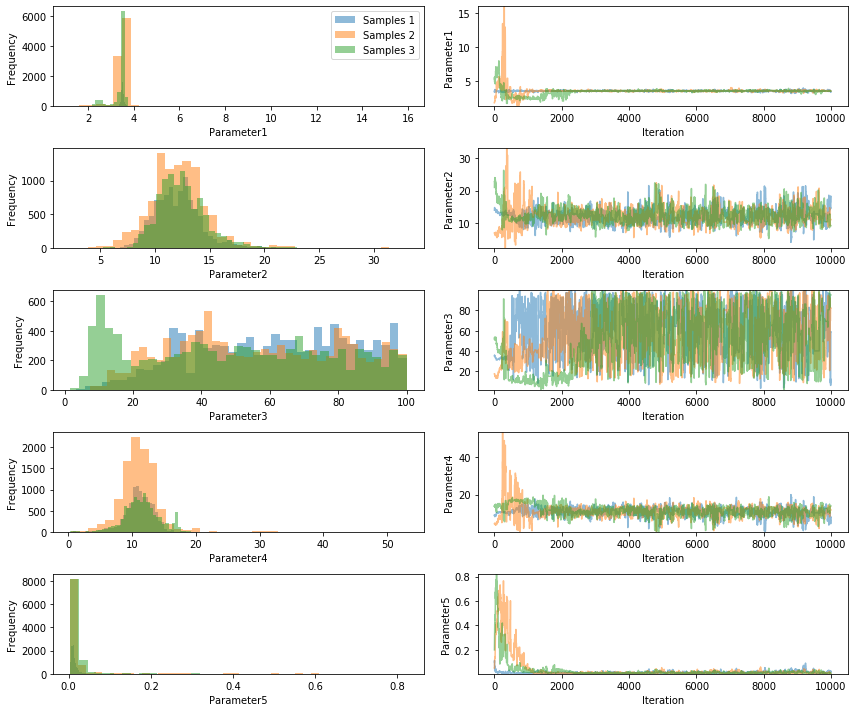

In [23]:
pints.plot.trace(samples)
plt.show()

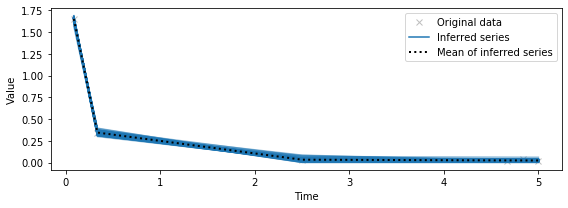

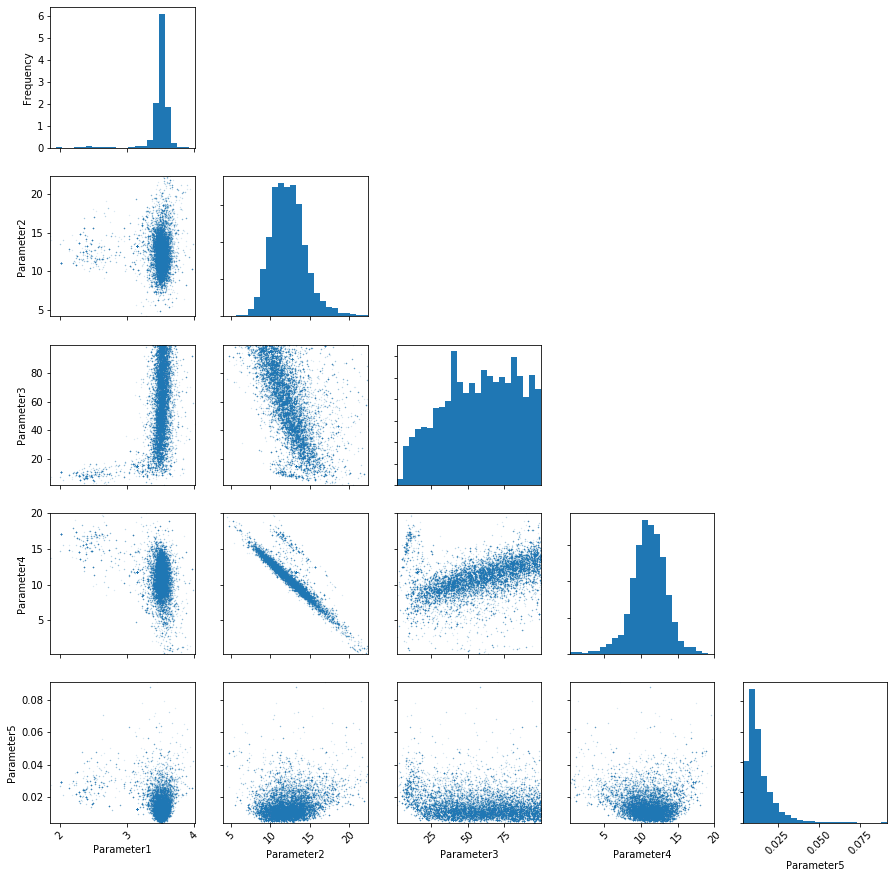

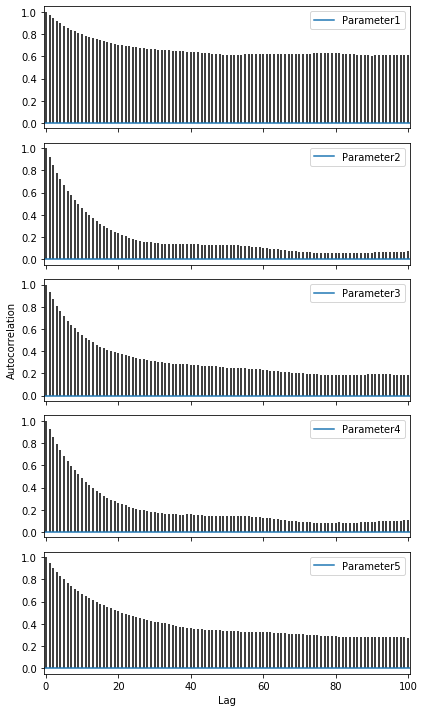

In [24]:
pints.plot.series(np.vstack(samples[:,1000:]), problem)
plt.show()
pints.plot.pairwise(np.vstack(samples[:,1000:]))
plt.show()
pints.plot.autocorrelation(np.vstack(samples[:,1000:]))
plt.show()